#Statistical mechanics of the quantum harmonic oscillator using path integral Markov Chain Monte Carlo (MCMC): a comparison of Metropolis-Hastings MCMC and Hamiltonian MCMC
Jared Rivera (in collaboration with Daniel Callos)

UCLA Physics 180N, Fall 2019


# **Abstract**

In general, thermodynamic quantities like the expectation value of the Hamiltonian are hard to solve for analytically due to the partition function becoming nontrivial for all but the simplest systems. In practice, approximation methods are used to solve for these quantities of interest. This project sought to find the estimate expectation value of the energy of a finite-temperature quantum harmonic oscillator by approximately solving Feynman path integrals. To do this, two Markov Chain Monte Carlo (MCMC) alogorithms were applied: Metropolis-Hastings, and Hamiltonian Monte Carlo with the Stormer Verlet method implemented as the symplectic integrator. Both methods were able to estimate the expectation value of the energy at various temperatures with acceptable accuracy, converging to the exact values over large numbers of iterations (~1e6) for two different imaginary time discretizations (N = 2 and N = 5). The Hamiltonian method was applied with the hope of seeing faster convergence, but the current implementation failed to provide that boost. However, this is likely due to user error as implied by the fact that a free particle ansatz (U=0) in the Hamiltonian method did provide a boost to convergence speed. This project shows proof-of-principle that path integral MCMC methods are suitable for approxmating the statistical mechanics of complex quantum systems. 

# **Physical System and Model**

### The Partition Function

In classical Statistical Mechanics, the probability of finding a system in state $s_i$ when in thermal equilibrium with a heat bath at temperature $T$ is given by the Boltzmann distribution

\begin{equation}
    p(\{s_i\}) = Z^{-1}e^{-E(\{s_i\})/T},
\end{equation}

where the partition function $Z$ is defined as

$$
Z = \sum e^{-E(\{s_i\})/T}
$$

Where the sum runs over all possible states.

To adapt this discussion to Quantum Statistical Mechanics, the  definition of the partition function becomes

\begin{align}
    Z(\beta) = \mathrm{tr}(e^{-\beta \hat H})
\end{align}
Where $\beta = \frac{1}{T}$

Generalization to a continuous position space representation for a one-dimensional system turns the sum over discrete diagonal matrix elements (the trace) into an integral over a continuous spectrum of states:

\begin{align}
    \mathrm{tr}(e^{-\beta \hat H}) = \int dq \langle q|e^{-\beta \hat H}|q\rangle
\end{align}

To prove this, consider the Quantum mechanics representations of the identity in position and momentum:

\begin{align}
    \hat I = \int dq\, |q\rangle\langle q|, \qquad \hat I = \int \frac{dp}{2\pi\hbar}\, |p\rangle\langle p|
\end{align}

With inner products of position and momentum eigenstates defined as

\begin{align}
    \langle q|p\rangle = e^{iqp/\hbar}, \qquad \langle p|q\rangle = e^{-ipq/\hbar}
\end{align}

we can consider the effec of inserting this quantum formalism into the trace for some general operator $\hat O$

\begin{align}
  \mathrm{tr}(\hat O) 
  &= \sum_n\langle n|\hat O|n\rangle \\
  &= \sum_n \langle n|\int dq |q\rangle\langle q| \hat O\int dq' |q'\rangle\langle q'||n\rangle\\
  &= \int dq\int dq'\langle q|\hat O|q'\rangle \sum_n\langle q'|n\rangle \langle n|q\rangle \\
  &= \int dq\int dq'\langle q|\hat O|q'\rangle \delta(q-q') \\
  &= \int dq \langle q|\hat O|q\rangle
\end{align}

This proves our original equation:

$$
    Z(\beta) = \int dq \,\langle q|e^{-\beta \hat H}|q\rangle
$$

### Discretization approximation

Note that

\begin{align}
    e^{\hat A + \hat B} = e^{\hat A}e^{\hat B}, \qquad [\hat A, \hat B] = 0.
\end{align}

More generally for $\epsilon > 0$

\begin{align}
    e^{\epsilon(\hat A + \hat B)} = e^{\epsilon \hat A}e^{\epsilon \hat B} + O(\epsilon^2)
\end{align}

where the $O(\epsilon^2)$ terms depend on the commutator $[\hat A, \hat B]$ in such a way that they vanish when the commutator vanishes.

Suppose that $\epsilon>0$ is a real number, then notice that

\begin{align}
    e^{\epsilon(\hat A + \hat B)}
    &= \hat I + \epsilon(\hat A + \hat B) + \frac{\epsilon^2}{2!}(\hat A + \hat B)^2 + \cdots
\end{align}

and

\begin{align}
    e^{\epsilon\hat A}e^{\epsilon\hat B} 
    &= (\hat I + \epsilon \hat A + O(\epsilon^2))(\hat I + \epsilon \hat B + O(\epsilon^2)) \\
    &= \hat I + \epsilon\hat A + \epsilon \hat B + O(\epsilon^2) \\
    &= \hat I + \epsilon(\hat A + \hat B) + O(\epsilon^2)
\end{align}

It follows that

\begin{align}
    e^{\epsilon(\hat A + \hat B)} = e^{\epsilon\hat A}e^{\epsilon\hat B} + O(\epsilon^2)
\end{align}

Therefore, if $\epsilon$ is small, we have approximately

\begin{align}
    e^{\epsilon(\hat A + \hat B)} \approx e^{\epsilon\hat A}e^{\epsilon\hat B}
\end{align}

This becomes useful if we perform some discretization on $q$ in imaginary time:

\begin{align}
    Z(\beta) 
    &= \int dq \,\langle q|e^{-\beta \hat H}|q\rangle \\
    &= \int dq_1 \,\langle q_1|e^{-\frac{\beta}{N} \hat H}e^{-\frac{\beta}{N} \hat H}\cdots e^{-\frac{\beta}{N} \hat H}|q_1\rangle \\
    &= \int dq_1\int dq_2\cdots \int dq_N \,\langle q_1|e^{-\frac{\beta}{N} \hat H}|q_N\rangle\langle q_N|e^{-\frac{\beta}{N} \hat H}|q_{N-1}\rangle\langle q_{N-1}|\cdots |q_2\rangle\langle q_2| e^{-\frac{\beta}{N} \hat H}|q_1\rangle \\
    &= \int d^N q \,\langle q_1|e^{-\frac{\beta}{N} \hat H}|q_N\rangle\langle q_N|e^{-\frac{\beta}{N} \hat H}|q_{N-1}\rangle\langle q_{N-1}|\cdots |q_2\rangle\langle q_2| e^{-\frac{\beta}{N} \hat H}|q_1\rangle
\end{align}

Define $\epsilon = \beta/N$ and suppose then

\begin{align}
    \hat H 
    &= \hat T + \hat V \\
    &= \frac{1}{2m}\hat P^2 + V(\hat Q)
\end{align}

\begin{align}
    \langle q_{i+1}|e^{-\frac{\beta}{N}\hat H}|q_{i}\rangle
    &= \langle q_{i+1}|e^{-\epsilon\hat H}|q_{i}\rangle \\
    &= \langle q_{i+1}|e^{-\epsilon(\hat T + \hat V)}|q_{i}\rangle \\
    &\approx \langle q_{i+1}|e^{-\epsilon\hat T}e^{-\epsilon\hat V}|q_{i}\rangle \\
    &= \int \frac{dp}{2\pi\hbar} \langle q_{i+1}|e^{-\epsilon\hat T}|p\rangle\langle p|e^{-\epsilon V(\hat Q)}|q_{i}\rangle \\
    &= \int \frac{dp}{2\pi\hbar} \,e^{-\epsilon p^2/2m}e^{-\epsilon V(q_{i})}\langle q_{i+1}|p\rangle\langle p|q_{i}\rangle \\
    &= \int \frac{dp}{2\pi\hbar} \,e^{-\epsilon p^2/2m}e^{-\epsilon V(q_{i})}e^{iq_{i+1}p/\hbar}e^{-iq_ip/\hbar}
\end{align}

Now we remember that the Fourier transform of a Gaussian is a Gaussian:

\begin{align}
    \int \frac{e^{-\frac{k^2}{2\sigma^2}}}{\sqrt{2\pi\sigma^2}} e^{ikx} \, dk
    &= e^{-x^2/(2/\sigma^2)}
\end{align}

so the above simplifies to

\begin{align}
    &= \frac{e^{-\epsilon V(q_{i})}}{2\pi\hbar} \sqrt{\frac{2\pi m}{\epsilon}}e^{-m(q_{i+1} - q_i) ^2/(2\epsilon\hbar ^2)} \\
    &= \frac{e^{-\epsilon V(q_{i})}}{(2\pi)^{1/2}} \sqrt{\frac{ m}{\epsilon\hbar^2}}\exp\left(-\frac{1}{2}\frac{(q_{i+1} - q_i)^2}{\epsilon\hbar ^2/m}\right) \\
    &= \frac{1}{(2\pi)^{1/2}A(\epsilon)} \exp\left[-\frac{1}{2}\left(\frac{q_{i+1} - q_i}{A(\epsilon)}\right)^2-\epsilon V(q_{i})\right]
\end{align}

Where
$$
\qquad A(\epsilon) \equiv \left(\frac{\epsilon\hbar^2}{m}\right)^{1/2}
$$

The $N$-discretized partition function of a quantum particle of mass $m$ moving in one dimension at inverse temperature $\beta$ subject to the potential $V(q)$ is

$$
    Z_N(\beta) = \int_{\mathbb R^N}\frac{d^Nq}{(2\pi)^{N/2}A(\epsilon)^N}\,\exp\left(-\sum_{i=1}^N\left[\frac{1}{2}\left(\frac{q_{i+1}-q_i}{A(\epsilon)}\right)^2 + \epsilon V(q_i)\right]\right)
$$

Where we take a periodic spatial boundary condition 
$$
\qquad q_{N+1} \equiv q_1
$$ 
because in equilibrium this position won't be changing over the discretized "imaginary time evolution".

### Adapting the formalism for use in MCMC

Letting, $u_i = q_i/A(\epsilon)$, the measure becomes independent of $\beta$, as does the "kinetic term" in the exponential:

$$
    Z_N(\beta) = \int_{\mathbb R^N}\frac{d^Nu}{(2\pi)^{N/2}}\,\exp\left(-\sum_{i=1}^N\left[\frac{1}{2}\left(u_{i+1}-u_i\right)^2 + \epsilon V\Big(A(\epsilon)u_i\Big)\right]\right)
$$

The ensemble average energy is

$$
  \langle \hat H\rangle_N 
  = - \frac{\partial}{\partial\beta} \ln Z_N 
  = - \frac{1}{Z_N} \frac{\partial Z_N}{\partial\beta} 
  = \frac{\int_{\mathbb R^N}d^Nu\,\frac{\partial}{\partial\beta}\left(\sum_{i=1}^N\epsilon V(A(\epsilon) u_i)\right) \exp\left(-\sum_{i=1}^N\left[\frac{1}{2}\left(u_{i+1}-u_i\right)^2 + \epsilon V\Big(A(\epsilon)u_i\Big)\right]\right)}{\int_{\mathbb R^N}d^Nu\,\exp\left(-\sum_{i=1}^N\left[\frac{1}{2}\left(u_{i+1}-u_i\right)^2 + \epsilon V\Big(A(\epsilon)u_i\Big)\right]\right)}
$$

Now notice that

$$
  \frac{\partial}{\partial\beta} = \frac{\partial}{\partial\epsilon}\frac{\partial\epsilon}{\partial\beta} = \frac{1}{N}\frac{\partial}{\partial\epsilon}
$$

and therefore the term in the integrand of the numerator is

$$
  \frac{\partial}{\partial\beta}\left(\sum_{i=1}^N\epsilon V(A(\epsilon) u_i)\right) = \frac{1}{N}\frac{\partial}{\partial\epsilon}\left(\sum_{i=1}^N\epsilon V(A(\epsilon) u_i)\right) = \frac{1}{N}\sum_{i=1}^N \left[V(A(\epsilon)u_i) + \epsilon V'(A(\epsilon) u_i)A'(\epsilon)u_i\right]
  = \frac{1}{N}\sum_{i=1}^N \left[V(A(\epsilon) u_i) + \frac{1}{2}(A(\epsilon)u_i)V'(A(\epsilon) u_i)\right]
$$

Plugging this back into the expression for the ensemble average energy, and reverting the integrals to the old variables $q_i$ and using the notation $\vec q = (q_1, q_2, \dots, q_N)$ gives

$$
  \langle \hat H\rangle_N = \frac{\int_{\mathbb R^N}d^Nq\,\Phi(\vec q) \,e^{-U(\vec q)}}{\int_{\mathbb R^N}d^Nq\,e^{-U(\vec q)}} 
$$
where
$$
  \qquad \Phi(\vec q) = \frac{1}{N}\sum_{i=1}^N\left[V(q_i) + \frac{1}{2}q_i V'(q_i)\right] 
$$
and
$$
  \qquad U(\vec q) = \sum_{i=1}^N\left[\frac{m}{2(\beta/N)\hbar^2}\left(q_{i+1}-q_i\right)^2 + (\beta/N) V(q_i)\right]
$$

This is now presented in a way that MCMC can be applied for a given potential since we have written the desired quantity as the expectation value of a certain function $\Phi$ on the space of vectors $\vec q$.  To apply the algorithm, one needs to sample points from this space according to the un-normalized probability distribution $e^{-U(\vec q)}$ using an algorithm of choice.

### Applying to the quantum harmonic oscillator

For the special case of the harmonic oscillator with potential $V(q) = \frac{1}{2}m \omega^2 q^2$ in contact with a heat bath at absolute temperature $T$, there is some probability $p_n(T)$ that the system will occupy each of its energy eigenstates proportional to the Boltzmann factor associated with that state.  This can be used to determine an expression for the average energy the system will have in equilibrium according to the above path integral derivations, yielding 

$$ e^{-U(\mathbf{q})} = \mathrm{exp} \bigg\{ -\frac{\|\mathbf{u}_{D}\|^{2} + \epsilon^{2}\hbar^{2}\omega^{2}\|\mathbf{u}\|^{2}}{2}\bigg\}$$

which in turn gives

$$\langle \mathbf{H}\rangle_{N} = \frac{\hbar^{2}\omega^{2}\epsilon}{N}\frac{ \int_{\mathbb{R}^{N}} \mathrm{d}^{N}\mathbf{u}  \mathrm{exp} \bigg\{ -\frac{\|\mathbf{u}_{D}\|^{2} + \epsilon^{2}\hbar^{2}\omega^{2} \|\mathbf{u}\|^{2}}{2} \bigg\}\|\mathbf{u}\|^{2} }{\int_{\mathbb{R}^{N}} \mathrm{d}^{N}\mathbf{u}  \mathrm{exp} \bigg\{ -\frac{\|\mathbf{u}_{D}\|^{2} + \epsilon^{2}\hbar^{2}\omega^{2}\|\mathbf{u}\|^{2}}{2}\bigg\}} $$

with

$$ \Phi(\vec{q}) = \frac{\hbar^{2}\omega^{2}\epsilon}{N}\|u\|^{2}$$

and

$$ \mathbf{u}_{D}^{\mu} = \mathbf{u}^{\mu + 1} - \mathbf{u}^{\mu} $$


Please note that this section makes heavy use of the LaTeX and organizational structure of the Appendix in reference [1].


# **Algorithms**

An algorithm is fundamentally a list of instructions, a protocol to be carried out in a consistent and logical fashion. This project makes heavy use of several algorithms for the purpose of speeding up computation. Pen and paper calculations have the appeal of providing analytic solutions to problems that will yield them, but many problems become intractable even if the unit processes are easy. Implementing robust algorithms on a computer allows repetitive, well-defined tasks to be solved much quicker than can be done by hand. Studying good algorithms also speeds up the code relative to a naive approach that a novice programmer may take. The main algorithms implemented in ths project are detailed below, but it should be noted that several more are taken advantage of through the NumPy package.

Let's first prove a useful identity that will reduce computational cost in this already expensive project. With a sequence $o_1, \dots, o_n$ of real numbers corresponding to measured values of some observable quantity $O$, the $k^\mathrm{th}$ running average of this sequence is defined as:
\begin{align}
    \langle O \rangle_k = \frac{o_1 + \cdots + o_k}{k}
\end{align}
Now consider the next step:
\begin{align}
    \langle O \rangle_{k+1} = \frac{o_1 + \cdots + o_k + o_{k+1}}{k+1}
\end{align}
We'd like to relate this simply to $\langle O \rangle_k$.

Separate the fraction as
\begin{align}
    \langle O \rangle_{k+1} = \frac{o_1 +  \cdots + o_k}{k+1} + \frac{o_{k+1}}{k+1}
\end{align}
Now use the first equation to argue
\begin{align}
    o_1 + \cdots + o_k = k\langle O \rangle_{k}
\end{align}
So that
\begin{align}
    \langle O \rangle_{k+1} = \frac{k}{k+1}\langle O \rangle_k + \frac{o_{k+1}}{k+1}
\end{align}
Which can be written as
\begin{align}
    \langle O \rangle_{k+1} = (1-\frac{1}{k+1})\langle O \rangle_k + \frac{o_{k+1}}{k+1}
\end{align}
Yielding
\begin{align}
    \langle O\rangle_{k+1} = \langle O\rangle_k + \frac{1}{k+1}(o_{k+1} - \langle O\rangle_k).
\end{align}

This is a useful identity because it means that if you're generating the sequence of $o_k$'s one after the other in, say, a loop, computing the running average on each iteration doesn't require summing up all of the previous values and dividing by the total number of values every single time -- you can simply update the prior running average by adding a change term that depends on the next value in the sequence and the current running average.


## Markov-Chain Monte-Carlo

A good description of MCMC is given in reference [3]: "A Markov chain is a probabilistic process the generates a sequence of possible states in which the probability of each state depends only on the previous state. MCMC works by generating Markov chains where the number of times a given state tends to appear is proportional to its probability."

There are many different implementations of MCMC algorithms, here we'll discuss two of them.

### Metropolis-Hastings algorithm

Following the organizational structure of reference [3], the MH implementation proceeds as follows:

1) Initiate an initial state $s_0$ of your choosing,
and successively generate states by following steps 2 through 4.

2) propose a new state $s'$ according a probability distribution $q$, defined
such that $q(s'|s)$ is the probability of proposing $s'$ given the current state is $s$.

3) Accept the proposed state with probability

$$
A(s'|s) = min \left( 1,\frac{p_{s'}q(s|s')}{p_{s}q(s'|s)} \right)
$$

If the state is not accepted, stay in the same state $s$.

The proposal distribution is often chosen to be symmetric to simplify the acceptance probability to

$$
A(s'|s) = min \left( 1,\frac{p_{s'}}{p_{s}} \right)
$$

4) Go back to step 2. 

### Hamiltonian Monte Carlo algorithm

The point of this method is to have energetically-informed proposed state generation (reference [4]). This allows higher probability of accepting states that are far from the current state. The only differnce from the MH method is in how the new state to be proposed is generated. To generate the proposal, follow the steps below:

1) Generate a random momentum by sampling from a Gaussian distribution. This mimicks the random velocities of colliding particles in a thermal bath.

2) Generate a proposed position state by evolving the current position state according to Hamilton's equations with the momentum from step 1. This requires the use of a numerical integrator (detailed below). Let's quickly review the Hamiltonian relevant to this sytem.

$$
H(q,p) = T(\vec p) + U(\vec q)
$$ 
where
$$
T(\vec p) = \frac{|\vec p|^2}{2m}
$$
and
$$
U(\vec q) = \sum_{i = 1}^{N} \left[ \frac{m}{2 \epsilon \hbar^2}(q_{i+1}-q_i)^2 + \epsilon(\frac{1}{2}m \omega^2 q_i^2) \right]
$$

Note that in general, $(\frac{\partial H}{\partial \vec x})_i = \frac{\partial H}{\partial x_i}$

For use in Hamilton's equations to be input to the SV solver,
$$
\left( \frac{\partial H}{\partial \vec p}\right)_i = \frac{p_i}{m}
$$

For the other partial, we need to consider multiple sum terms since $q_i$ also shows up in the $i-1$ term as seen below

$$
\frac{\partial U}{\partial q_i} \propto (q_{i+1} - q_i)
$$
and
$$
\frac{\partial U}{\partial q_{i-1}} \propto (q_i - q_{i-1})
$$

Keeping track of constants, grouping terms in $q_i$, and doing some algebra yields

$$
\left( \frac{\partial H}{\partial \vec q}\right)_i = (\frac{2m}{\epsilon \hbar^2} + \epsilon m \omega^2)q_i - \frac{m}{\epsilon \hbar^2}(q_{i+1} + q_{i-1})
$$

Now discrete, known values can be passed into the SV integrator. Note that $U$ can naively be chosen to be 0, like a free particle, but this is less effective and less interesting (though it proved useful in debugging).

#### Stormer-Verlet integrator
  
This is a symplectic method that conserves energy in the system. The implementation is as follows:

$$
p_{k,n+\frac{1}{2}} = p_{k,n} - \frac{h}{2}\frac{\partial H}{\partial q^k}(\vec q_n,\vec p_n)
$$
$$
q_{n+1}^k = q_n^k + h\frac{\partial H}{\partial p_k}(\vec q_n,\vec p_{k,n+\frac{1}{2}})
$$
$$
p_{k,n+1} = p_{k,n+\frac{1}{2}} - \frac{h}{2}\frac{\partial H}{\partial q^k}(\vec q_{n+1},\vec p_n)
$$

As in reference [2].

The rest of the MCMC algorithm proceeds like MH.


# **Code**

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def get_prob(q, j, qj_new, omega, epsilon, N):
  """"""
  factor = 0.5 * ( hbar * omega * epsilon )**2.0
  term1 = qj_new**2.0 - q[j]**2.0
  term2 = (q[j] - qj_new) * (q[j] + qj_new - q[(j-1) % N] - q[(j+1) % N])
  dU = factor * term1 - term2 #U_prop - U_current
  return np.exp(-dU)

def get_phi(q, m, omega, N):
  """"""
  return m * omega**2 * np.linalg.norm(q)**2 / N

def true_H(omega, T, N_dims):
    """"""
    beta = 1.0 / (kB * T)
    N_dims = float(N_dims)
    a = (beta * hbar) / N_dims
    W = omega * np.sqrt( (0.5*a*omega)**2.0 + 1.0 )
    R = 1.0 + 0.5*(a * omega)**2.0 - a*omega*np.sqrt( (0.5*a*omega)**2.0 + 1.0 )
    U = 0.5 * hbar * omega * omega * (1 + R**N_dims) / (W * (1.0 - R**N_dims))
    return U

def get_expec(O_prev,o_new,n): #n is the index of O_prev
    """"""
    O_new = O_prev + (o_new - O_prev) / float(n+1)
    return O_new

################################################################################

def mh_update(omega, epsilon, N_pts, state, current):
  """"""
  j = np.random.randint(0,N_pts)
  a = epsilon * hbar
  delta = 1.0 / a
  qj_new = state[j] + np.random.uniform(-delta, delta)
  prob = get_prob(state,j,qj_new,omega,epsilon,N_pts)
    
  alpha = min(1.0, prob)
  if alpha == 1.0:
    current += qj_new**2 - state[j]**2
    state[j] = qj_new 
  else:
    u = np.random.uniform(0,1)
    if u <= alpha:
        current += qj_new**2 - state[j]**2
        state[j] = qj_new
  return state, current

################################################################################

def d_qH(q,p,qm1,qp1,epsilon):
    """"""
    ans = (2*m/(epsilon*hbar**2))*q-(m/(epsilon*hbar**2))*(qp1 + qm1)
    return ans
  
def d_pH(q,p):
    """"""
    return p/m

def sv_solve(d_qH, d_pH, t_0 = 0.0, q_0 = 0.0, p_0 = 1.0, h = 0.1, N = 100, qm1 = 0.0, qp1 = 0.0,epsilon = 1.0):
    """"""
    P = np.zeros(N+1)
    Q = np.zeros(N+1)
    Q[0] = q_0
    P[0] = p_0
    for n in range(N):
      Phalf = P[n] - (h/2) * d_qH(Q[n], P[n],qm1,qp1,epsilon)
      Q[n + 1] = Q[n] + h * d_pH(Q[n], Phalf)
      P[n + 1] = Phalf - (h/2) * d_qH(Q[n+1], P[n],qm1,qp1,epsilon)
    return Q[n + 1]

def hmc_update(omega, epsilon, N_pts, state, current):
  """"""
  beta = epsilon * N_pts
  h = 0.01/(omega * epsilon * hbar)
  N = 100

  #Get a random momentum from a normal distribution
  mu, sigma = 0, 0.1 # mean and standard deviation
  p_0 = np.random.normal(mu, sigma, 1)
  j = np.random.randint(0,N_pts)

  #Find a state using sv_solve to get a proposal
  q_0 = state[j]
  if j == 0:
    qm1 = N_pts - 1
    qp1 = j + 1
  elif j == (N_pts-1):
    qm1 = j - 2
    qp1 = 0
  else:
    qm1 = j - 1
    qp1 = j + 1

  qj_new = sv_solve(d_qH, d_pH, 0, q_0, p_0, h, N, state[qm1], state[qp1],epsilon)

  prob = get_prob(state,j,qj_new,omega,epsilon,N_pts)
  alpha = min(1.0, prob)
  if alpha == 1.0:
    current += qj_new**2 - state[j]**2
    state[j] = qj_new 
  else:
    u = np.random.uniform(0,1)
    if u <= alpha:
        current += qj_new**2 - state[j]**2
        state[j] = qj_new
  return state, current

################################################################################

def run_mcmc(N_pts, N_iter, omega, T, method="Metropolis-Hastings"):
    """"""
    epsilon = 1.0 / (N_pts * T)
    state = np.random.rand(N_pts)
    current = np.linalg.norm(state)**2
    k = 0
    avgarr = []
    for i in range(1, N_iter):
        for n in range(N_pp):
            if method=="Metropolis-Hastings":
              state, current = mh_update(omega, epsilon, N_pts, state, current)
            elif method=="Hamiltonian":
              state, current = hmc_update(omega, epsilon, N_pts, state, current)
        if (i > N_iter / 10) and ( (i + 1) % 10 == 0 ):
            if k==0:  avg = current
            else:  avg = get_expec(avg, current, k)
            k+=1
            avgarr.append(avg)
    prefact = (hbar * omega )**2 * epsilon / N_pts
    avgarr=np.array(avgarr)
    return prefact*avgarr,state


# **Results**

Below I call the run_mcmc function for both methods to get an estimate of the expectation value of the energy. The main result of interest is showing that this method can recreate the temperature dependence of the result. However, before doing that, runs must be done to determine how many iterations are needed for the MCMC output to converge. This is the Convergence Test.

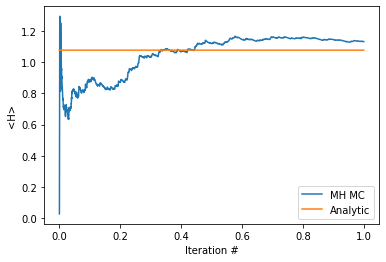

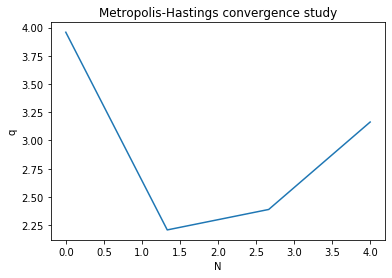

In [2]:
#Metropolis-Hastings Convergence Test

N_pts = int(4) #number of points in path
N_iter = int(1e5) #number of iterations per point
N_pp = int(5) #intermediate iterations per point
omega = 1.0
beta1 = 1.0
m = 1.0
hbar = 1.0
kB = 1
T1 = 1/beta1

#Imaginary time evolution
Hexpec,state = run_mcmc(N_pts, N_iter, omega, T1, "Metropolis-Hastings")

#Look at energy convergence
U = true_H(omega, T1, N_pts)
Uarr = np.zeros(len(Hexpec)) + U

index = np.linspace(0,N_iter,len(Hexpec))
plt.plot(index,Hexpec)
plt.plot(index,Uarr)
plt.title("Metropolis-Hastings convergence study")
plt.xlabel("Iteration #")
plt.ylabel("<H>")
plt.legend(('MH MC','Analytic'));
plt.show()

#Look at q
time = np.linspace(0,len(state),len(state))
plt.plot(time,state)
plt.xlabel("N")
plt.ylabel("q")
plt.show()


As seen above, convergence is seen on the order of 1e5 iterations.

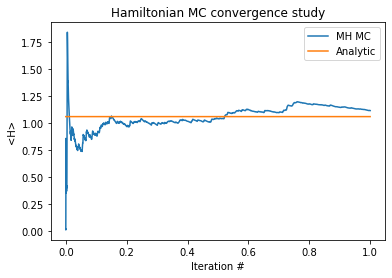

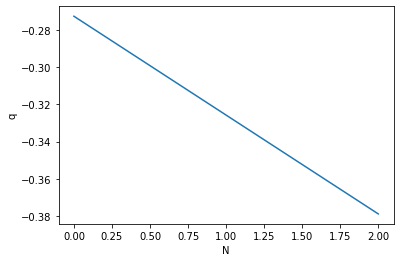

In [3]:
#Hamiltonian Convergence Test
N_pts = int(2) #number of points in path
N_iter = int(9e5) #number of iterations per point
N_pp = int(5) #intermediate iterations per point
omega = 1.0
beta2 = 1.0
m = 1.0
hbar = 1.0
kB = 1
T2 = 1/beta2

#Imaginary time evolution
Hexpec,state = run_mcmc(N_pts, N_iter, omega, T2, "Hamiltonian")

#Look at energy convergence
U = true_H(omega, T2, N_pts)
Uarr = np.zeros(len(Hexpec)) + U

index = np.linspace(0,N_iter,len(Hexpec))
plt.plot(index,Hexpec)
plt.plot(index,Uarr)
plt.title("Hamiltonian MC convergence study")
plt.xlabel("Iteration #")
plt.ylabel("<H>")
plt.legend(('MH MC','Analytic'));
plt.show()

#Look at q
time = np.linspace(0,len(state),len(state))
plt.plot(time,state)
plt.xlabel("N")
plt.ylabel("q")
plt.show()

As seen above, convergence is seen on the order of 1e6 iterations. This is larger than the other methodm, which was actually a surprise. In testing, the Hamiltonian method was implemented with $U=0$ and showed a speed up compared to Metropolis-Hastings. This may be evidence that my implementation of the potential has a bug.

Now look at $\frac{U}{\hbar \omega}$ vs. $\beta \hbar \omega$ like in reference [5], which will help us understand how the expectation value of the energy changes with temperature. 

The analytic solution is given in reference [5] as

$$
U = \frac{1}{2} \hbar \omega \left[ \frac{\omega (1+R^N)}{\Omega (1-R^N} \right]
$$
where N is the discretization number, $\Omega$ is defined following 
$$
\Omega^2 = \omega^2 (1+\frac{1}{4}a^2 \omega^2)
$$
with $a = \epsilon \hbar$

and 

$$
R = 1 + \frac{1}{2}a^2 \omega^2 - a \omega (1+\frac{1}{4}a^2 \omega^2)^\frac{1}{2}
$$

This function for $U$ is defined as a function in the larger code body above and is called to compare the two MCMC methods to below.

In [0]:
#Parametrize discrete system
N_pts = int(2) #number of points in path
N_iter = int(3e3) #number of iterations per point
N_pp = int(5) #intermediate iterations per point
omega = 1.0
m = 1.0
hbar = 1.0
kB = 1

#Analytic
Uanalytic = np.zeros(100)
betaan = np.linspace(0.2,4,100)

for i in range(100):
  Uanalytic[i] = true_H(omega, 1/betaan[i], 4)

#THESE TWO BELOW NEED TO BE GUARANTEED CONVERGED!
betaarr = np.asarray([4,2,1,0.5])
Hexpechmc = np.zeros(len(betaarr))
statehmc = np.zeros(len(betaarr))
Hexpecmhmc = np.zeros(len(betaarr))
statemhmc = np.zeros(len(betaarr))

for t in range(len(betaarr)):
  #Hamiltonian MCMC
  Hexpechmct,statehmc = run_mcmc(N_pts, int(3e5)*(t+1), omega, 1/(betaarr[t]), "Hamiltonian")
  Hexpechmc[t] = Hexpechmct[-1]

  #Metropolis-Hastings MCMC
  Hexpecmhmct,statemhmc = run_mcmc(N_pts, N_iter*(t+1), omega, 1/(betaarr[t]), "Metropolis-Hastings")
  Hexpecmhmc[t] = Hexpecmhmct[-1]


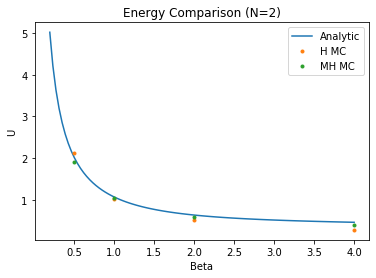

In [5]:
#Plot to compare
plt.plot(betaan,Uanalytic)
plt.plot(betaarr,Hexpechmc,'.')
plt.plot(betaarr,Hexpecmhmc,'.')
plt.title("Energy Comparison (N=2)")
plt.xlabel("Beta")
plt.ylabel("U")
plt.legend(('Analytic','H MC', 'MH MC'));
plt.show()

As seen here, the MCMC methods do a fantastic job estimating the analytic values for N=2. Note that the number of iterations changes with beta, as more are needed at higher temperature to achieve convergence. This results in long computational times if high temperatures are to be investigated.

In [0]:
#Parametrize discrete system
N_pts = int(5) #number of points in path
N_iter = int(3e3) #number of iterations per point
N_pp = int(5) #intermediate iterations per point
omega = 1.0
m = 1.0
hbar = 1.0
kB = 1

#Analytic
Uanalytic = np.zeros(100)
betaan = np.linspace(0.2,4,100)

for i in range(100):
  Uanalytic[i] = true_H(omega, 1/betaan[i], 4)

#THESE TWO BELOW NEED TO BE GUARANTEED CONVERGED!
betaarr = np.asarray([4,2,1,0.5])
Hexpechmc = np.zeros(len(betaarr))
statehmc = np.zeros(len(betaarr))
Hexpecmhmc = np.zeros(len(betaarr))
statemhmc = np.zeros(len(betaarr))

for t in range(len(betaarr)):
  #Hamiltonian MCMC
  Hexpechmct,statehmc = run_mcmc(N_pts, int(9e5)*(t+1), omega, 1/(betaarr[t]), "Hamiltonian")
  Hexpechmc[t] = Hexpechmct[-1]

  #Metropolis-Hastings MCMC
  Hexpecmhmct,statemhmc = run_mcmc(N_pts, N_iter*(t+1), omega, 1/(betaarr[t]), "Metropolis-Hastings")
  Hexpecmhmc[t] = Hexpecmhmct[-1]


In [0]:
#Plot to compare
plt.plot(betaan*hbar*omega,Uanalytic/(hbar*omega))
plt.plot(betaarr*hbar*omega,Hexpechmc/(hbar*omega),'.')
plt.plot(betaarr*hbar*omega,Hexpecmhmc/(hbar*omega),'.')
plt.title("Energy Comparison (N=5)")
plt.xlabel("Beta")
plt.ylabel("U")
plt.legend(('Analytic','H MC', 'MH MC'));
plt.show()

The N=5 case takes even longer as more iterations are needed, but as seen above the analytic result is recreated by the approximate numerical methods extremely well. This shows that both MCMC methods are valid approaches to estimating solutions to the path integral.

## Performance analysis

Takes a couple hours to run. I wanted to use JIT, but there were some compatibility issues that I didn't care to take the time to iron out. Looking at what processes took the longest,

In [0]:
%prun run_mcmc(2, int(3e3), 1, 1, "Hamiltonian") #output shown below

Open the cell below to see the clear table structure, showing that $svsolve$ and $dqh$ are the slowest calls right now. To me, this is more evidence of an issue with Hamiltonian method impleentation in some way.

4731451 function calls (4731450 primitive calls) in 6.565 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    14995    3.725    0.000    5.981    0.000 <ipython-input-2-cb542ce6a866>:64(sv_solve)
  2999000    1.945    0.000    1.945    0.000 <ipython-input-2-cb542ce6a866>:55(d_qH)
  1499500    0.285    0.000    0.285    0.000 <ipython-input-2-cb542ce6a866>:60(d_pH)
    14995    0.138    0.000    0.217    0.000 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
    14995    0.101    0.000    0.101    0.000 <ipython-input-2-cb542ce6a866>:5(get_prob)
    14995    0.098    0.000    6.541    0.000 <ipython-input-2-cb542ce6a866>:76(hmc_update)
    14995    0.097    0.000    0.097    0.000 {method 'normal' of 'numpy.random.mtrand.RandomState' objects}
     7468    0.036    0.000    0.036    0.000 {method 'uniform' of 'numpy.random.mtrand.RandomState' objects}
    29990    0.026    0.000    0.026    0.000 {built-in method numpy.zeros}
    14995    0.025    0.000    0.080    0.000 _dtype.py:319(_name_get)
        1    0.022    0.022    6.565    6.565 <ipython-input-2-cb542ce6a866>:115(run_mcmc)
    29990    0.020    0.000    0.033    0.000 numerictypes.py:293(issubclass_)
    14995    0.019    0.000    0.055    0.000 numerictypes.py:365(issubdtype)
    44987    0.017    0.000    0.017    0.000 {built-in method builtins.issubclass}
    14995    0.011    0.000    0.011    0.000 {built-in method builtins.min}
      2/1    0.001    0.001    0.001    0.001 {built-in method numpy.core._multiarray_umath.implement_array_function}
      269    0.001    0.000    0.001    0.000 <ipython-input-2-cb542ce6a866>:27(get_expec)
        1    0.000    0.000    0.000    0.000 {method 'rand' of 'numpy.random.mtrand.RandomState' objects}
      270    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.001    0.001 linalg.py:2325(norm)
        1    0.000    0.000    6.565    6.565 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'ravel' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {built-in method numpy.array}
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(norm)
        1    0.000    0.000    6.565    6.565 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _asarray.py:16(asarray)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(dot)
        1    0.000    0.000    0.000    0.000 linalg.py:121(isComplexType)
        1    0.000    0.000    0.000    0.000 linalg.py:2321(_norm_dispatcher)
        1    0.000    0.000    0.000    0.000 multiarray.py:707(dot)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

## Conclusion and Outlook

This scheme obviously works and converges fairly quickly compared to many numerical methods. It can be applied to other Hamiltonians, often times trivially. There are some cases where it's harder due to things like singularities (reference [6]) but when applied it can yield novel info. If you want to stay with the harmonic oscillator potential, it's still useful in approximation schemes like the approximation of the nuclear potential in the Nuclear Shell Model (reference [7]).


# References

[1] Samani, J., 2019. Project 4 - Instructions. UCLA Physics 180N. 


[2] Samani, J., 2019. lecture-4-notes. UCLA Physics 180N. 

[3] Samani, J., 2019. lecture-7-notes. UCLA Physics 180N.

[4] Betancourt, Michael. "A conceptual introduction to Hamiltonian Monte Carlo." arXiv preprint arXiv:1701.02434 (2017).

[5] Larsen, Å. and Ravndal, F., 1988. The harmonic oscillator at finite temperature using path integrals. American Journal of Physics, 56(12), pp.1129-1133. (https://aapt.scitation.org/doi/abs/10.1119/1.15737)

[6] Duru, I. H., and H. Kleinert. "Quantum Mechanics of H‐Atom from Path Integrals." Fortschritte der Physik 30.8 (1982): 401-435.

[7] Militzer, B. Path Integral Monte Carlo Simulations of Hot Dense Hydrogen Ph. D. Diss. thesis, University of Illinois at Urbana-Champaign p145, 2000.
